# Fit tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("../src")

from stochastic_glv_generator import *
from experiments import *
from analysis import *
from inference import *

In [3]:
n = 2
seed = 12345
r_max = 1.
A_diag_mean = -2
A_diag_std = 1.
A_off_diag_std = 1.

p = sort_glv_params(n, seed, r_max, A_diag_mean, A_diag_std, A_off_diag_std)
r = p[:n]
A = p[n:].reshape((n, n))
x_eq = -np.linalg.inv(A)@r
print(x_eq)

env_noise = 0.0
t0 = 0
dt = 1e-2

np.random.seed(123)

# init_cond_list = init_cond_by_growth(x_eq, 0.1, 1)
init_cond_list = init_cond_by_perturb(x_eq, 2, [[-1, 1]], 1)

t_samp_list = np.linspace(0, 20, 10).reshape((1,-1))

meas_noise_list = np.array([0.0])
repetitions = 1

replicates = gen_replicates(p, env_noise, init_cond_list, t0, dt, t_samp_list, meas_noise_list, repetitions, seed=0, scale_meas_noise_by_abund=True, save_datasets=True)

new matrix 1[0.31755239 0.1952985 ]
1/1                                                                                                 

In [4]:
add_time_diff(replicates)
add_log_time_diff(replicates)

In [5]:
replicates

,dataset,measurement_noise,time,dt,sp1,sp2,dsp1/dt,dsp2/dt,dlogsp1/dt,dlogsp2/dt
0,0.0,0.0,0.000000,2.222222,0.074813,0.194939,0.070198,-0.012297,0.506968,-0.067962
1,0.0,0.0,2.222222,2.222222,0.230809,0.167614,0.032543,0.005508,0.122652,0.031716
2,0.0,0.0,4.444444,2.222222,0.303127,0.179854,0.005432,0.004365,0.017574,0.023635
3,0.0,0.0,6.666667,2.222222,0.315199,0.189553,0.000837,0.001742,0.002646,0.009095
4,0.0,0.0,8.888889,2.222222,0.317058,0.193423,0.000165,0.000581,0.000521,0.002996
5,0.0,0.0,11.111111,2.222222,0.317425,0.194715,0.000041,0.000182,0.000129,0.000932
6,0.0,0.0,13.333333,2.222222,0.317516,0.195118,0.000012,0.000056,0.000037,0.000288
7,0.0,0.0,15.555556,2.222222,0.317541,0.195243,0.000003,0.000017,0.000011,0.000088
8,0.0,0.0,17.777778,2.222222,0.317549,0.195282,0.000001,0.000005,0.000003,0.000027
9,0.0,0.0,20.000000,NaN,0.317551,0.195293,NaN,NaN,NaN,NaN


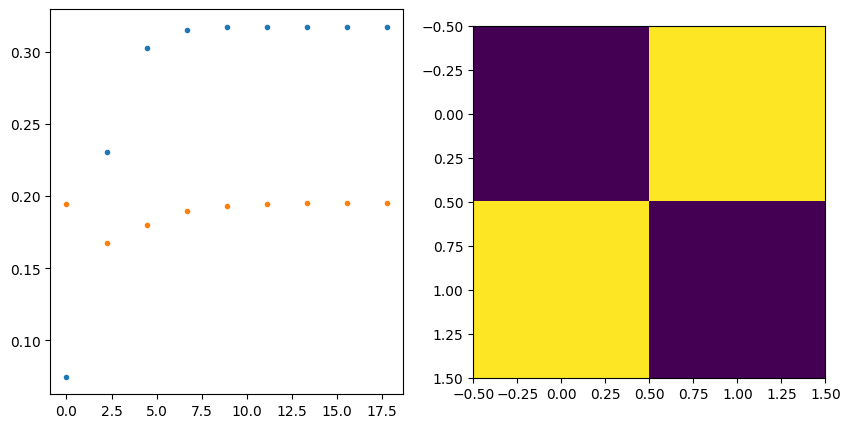

In [7]:
t = replicates.dropna()["time"].values
dt_arr = replicates.dropna()["dt"].values
y = replicates.dropna()[[i for i in replicates.columns if i[:2]=="sp"]].values
dydt = replicates.dropna()[[i for i in replicates.columns if i[:3]=="dsp"]].values
dlogydt = replicates.dropna()[[i for i in replicates.columns if i[:6]=="dlogsp"]].values

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(A))
plt.show()

1.0


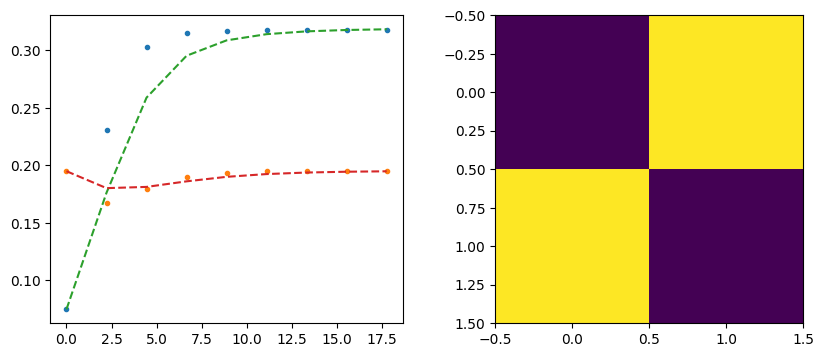

In [8]:
preg = fit_ridge_cv(replicates)
preg = np.concatenate((preg[0], preg[1].flatten()))

sol_reg = euler_maruyama(glv, t[0], y[0], preg, 0., dt, t)
plt.subplots(1, 2, figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.plot(t, sol_reg, "--")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(preg[n:].reshape((n,n))))

print((np.sign(preg[n:])==np.sign(p[n:])).sum()/n**2)

In [9]:
p0_list = np.random.normal(0, 2, (100, n*(n+1)))

p_lm = lm_fit(glv_for_fit, y, dydt.flatten(), p0_list)

100%|██████████| 100/100 [00:00<00:00, 613.90it/s]


1.0


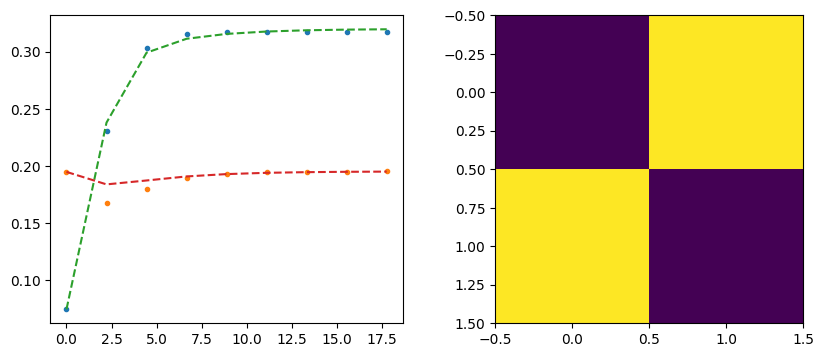

In [10]:
sol3 = euler_maruyama(glv, t[0], y[0], p_lm[-17], 0., dt, t)
plt.subplots(1, 2, figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.plot(t, sol3, "--")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(p_lm.mean(0)[n:].reshape((n,n))))

print((np.sign(p_lm.mean(0)[n:])==np.sign(p[n:])).sum()/n**2)

In [11]:
p

array([ 0.92961609,  0.31637555, -3.10071894,  0.28174615,  0.76902257,
       -2.87037789])

In [12]:
preg

array([ 0.30010766,  0.29379586, -2.06796265,  1.84219155,  0.27826887,
       -1.95931976])

In [13]:
p_lm[0]

array([ 0.18440426,  0.30107921, -3.46656565,  4.73363955,  0.25953001,
       -1.96622401])

In [14]:
dt_arr.reshape((-1,1)) * y * (r + np.dot(y, A.T))

array([[ 1.25115030e-01, -8.04196523e-02],
       [ 1.33954892e-01,  4.75191359e-03],
       [ 2.71997676e-02,  1.32847773e-02],
       [ 3.97815964e-03,  6.18486449e-03],
       [ 7.08338235e-04,  2.15067333e-03],
       [ 1.63164929e-04,  6.82670895e-04],
       [ 4.47019108e-05,  2.12027723e-04],
       [ 1.31688720e-05,  6.52929503e-05],
       [ 3.98403494e-06,  2.00516664e-05]])

In [15]:
mse(glv_for_fit(y, *preg), dydt.flatten())

6.0081690406451074e-05

In [16]:
mse(glv_for_fit(y, *p_lm[0]), dydt.flatten())

1.4297570237051259e-05

In [17]:
mse(euler_maruyama(glv, t[0], y[0], p, 0., dt, t), y)

0.0

In [18]:
mse(euler_maruyama(glv, t[0], y[0], preg, 0., dt, t), y)

0.000310857077217529

In [19]:
mse(euler_maruyama(glv, t[0], y[0], p_lm[0], 0., dt, t), y)

2.350387270024564e-05

/home/valeriano/Documents/BEPE/gLV_OED/notebooks/../src/stochastic_glv_generator.py:76: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  rhs_time[i] = x[i] * (r + np.dot(A, x[i]))
/tmp/ipykernel_2652/2928885897.py:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(F))


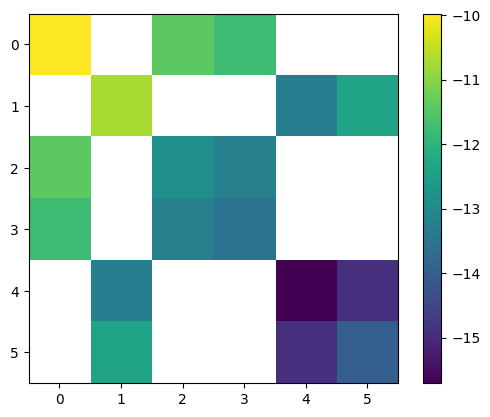

In [20]:
S = np.expand_dims(glv_time(t, y, p)-dydt, axis=-1)*glv_jac_time(t, y, p)
S = np.concatenate(S, 0)
F = S.T@S

plt.imshow(np.log(F))
plt.colorbar()

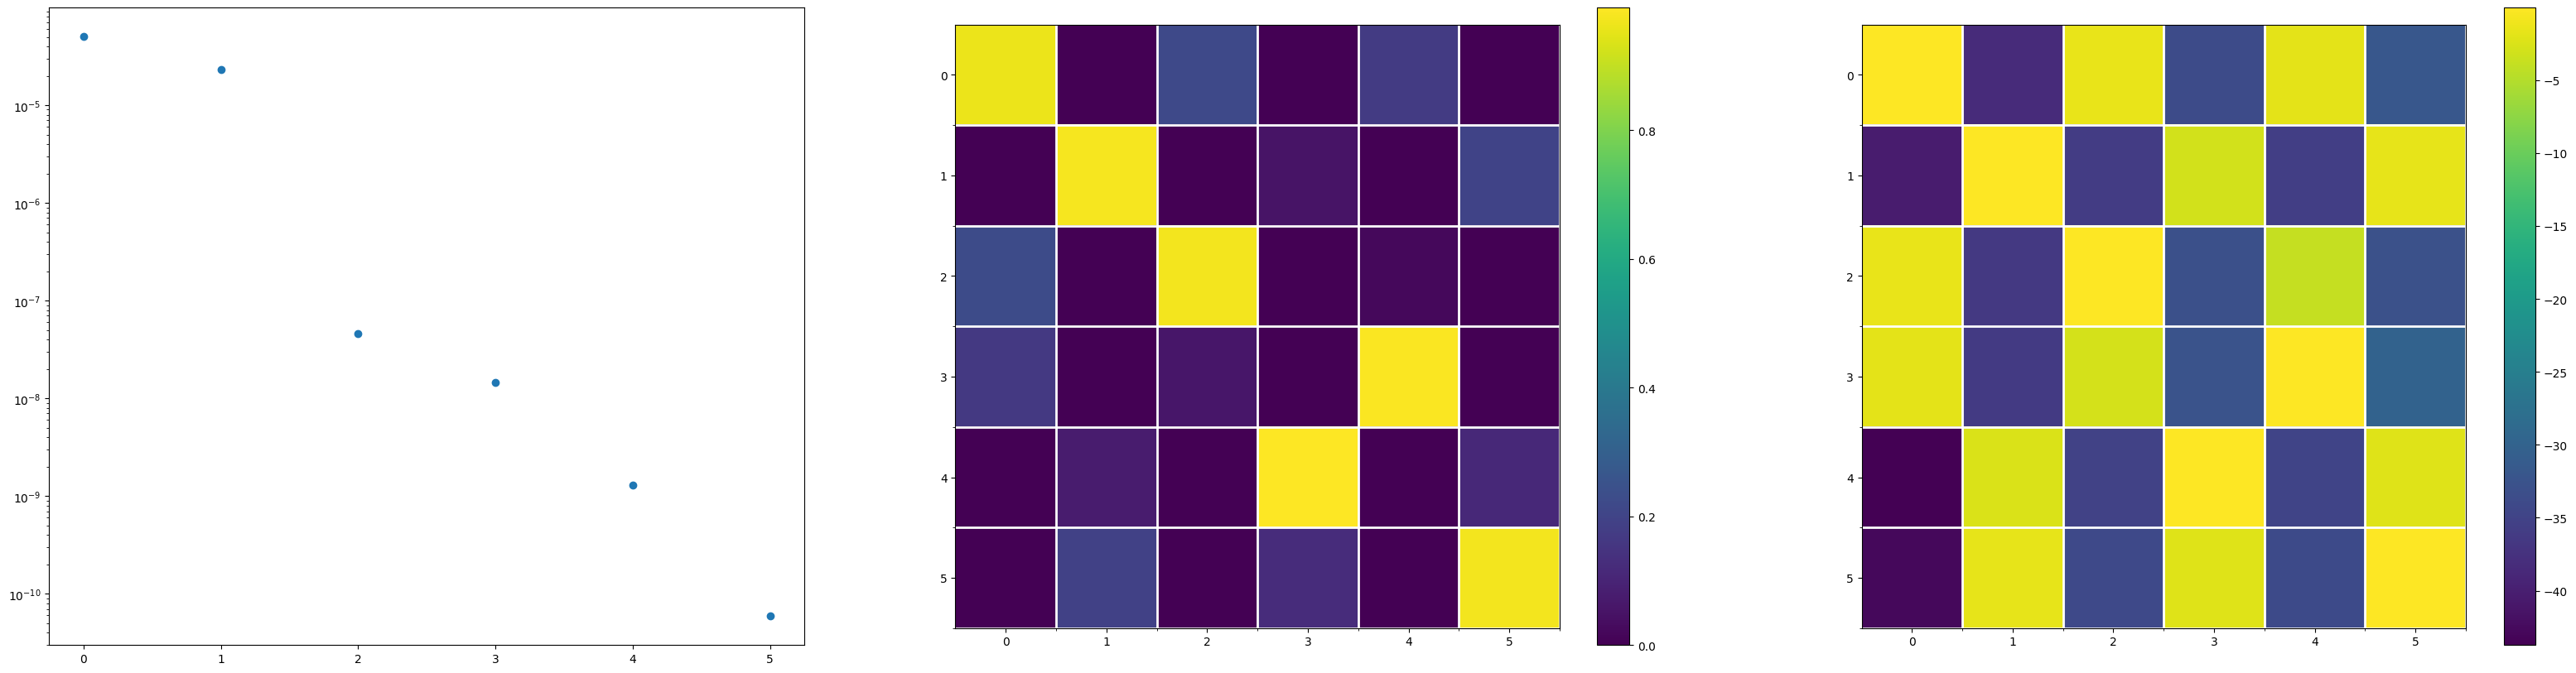

In [21]:
eigvals, eigvecs = np.linalg.eig(F)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

/tmp/ipykernel_2652/3687873738.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Freg))


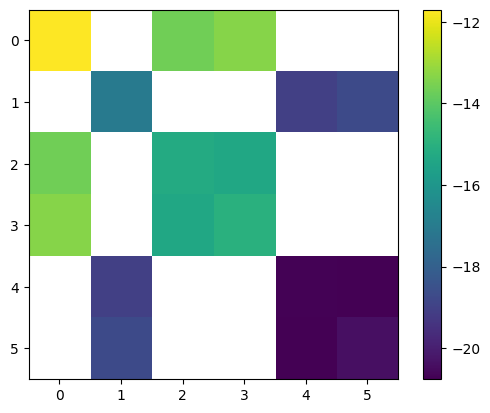

In [22]:
Sreg = np.expand_dims(glv_time(t, y, preg)-dydt, axis=-1)*glv_jac_time(t, y, preg)
Sreg = np.concatenate(Sreg, 0)
Freg = Sreg.T@Sreg
plt.imshow(np.log(Freg))
plt.colorbar()

/tmp/ipykernel_2652/4182083441.py:17: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(eigvecs)))


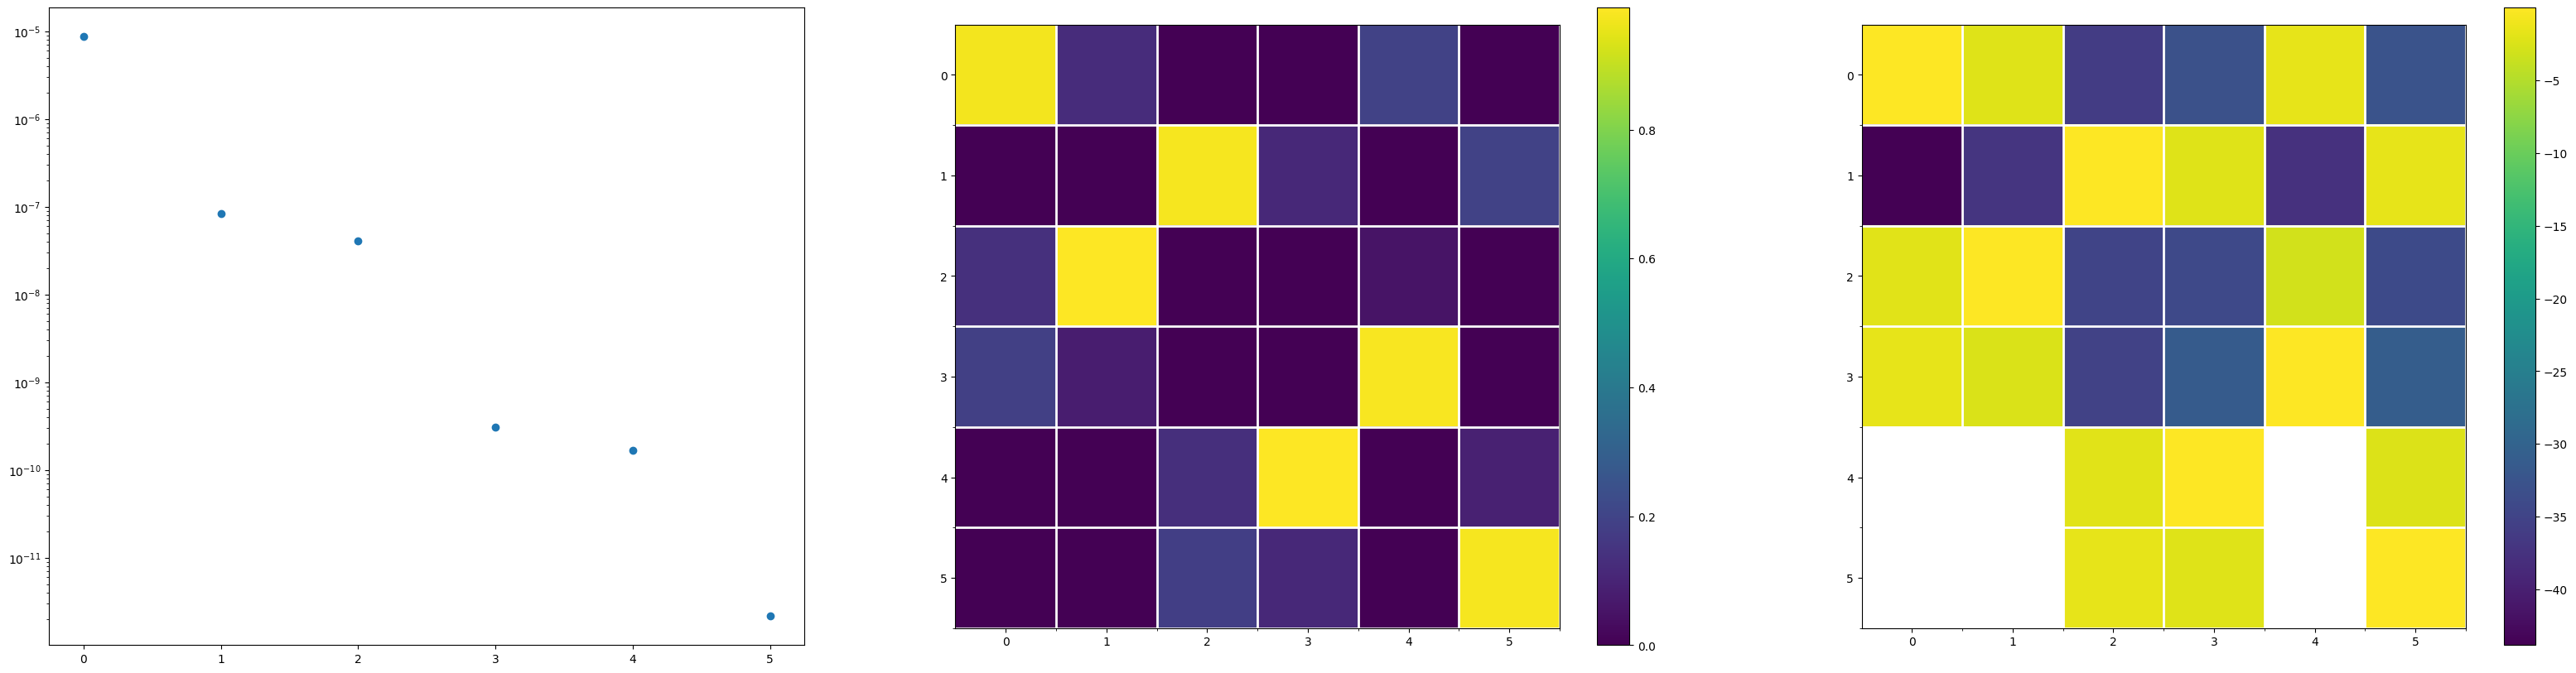

In [23]:
eigvals, eigvecs = np.linalg.eig(Freg)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

/tmp/ipykernel_2652/748564111.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(F4))


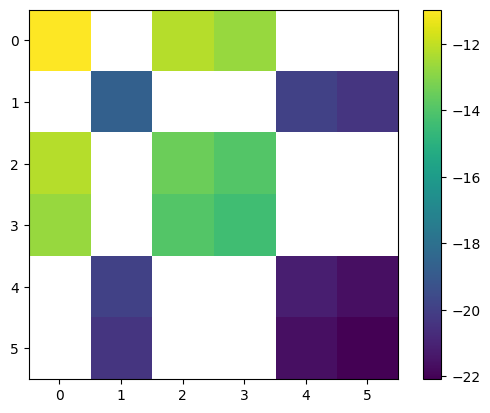

In [24]:
S4 = np.expand_dims(glv_time(t, y, p_lm[0])-dydt, axis=-1)*glv_jac_time(t, y, p_lm[0])
S4 = np.concatenate(S4, 0)
F4 = S4.T@S4
plt.imshow(np.log(F4))
plt.colorbar()

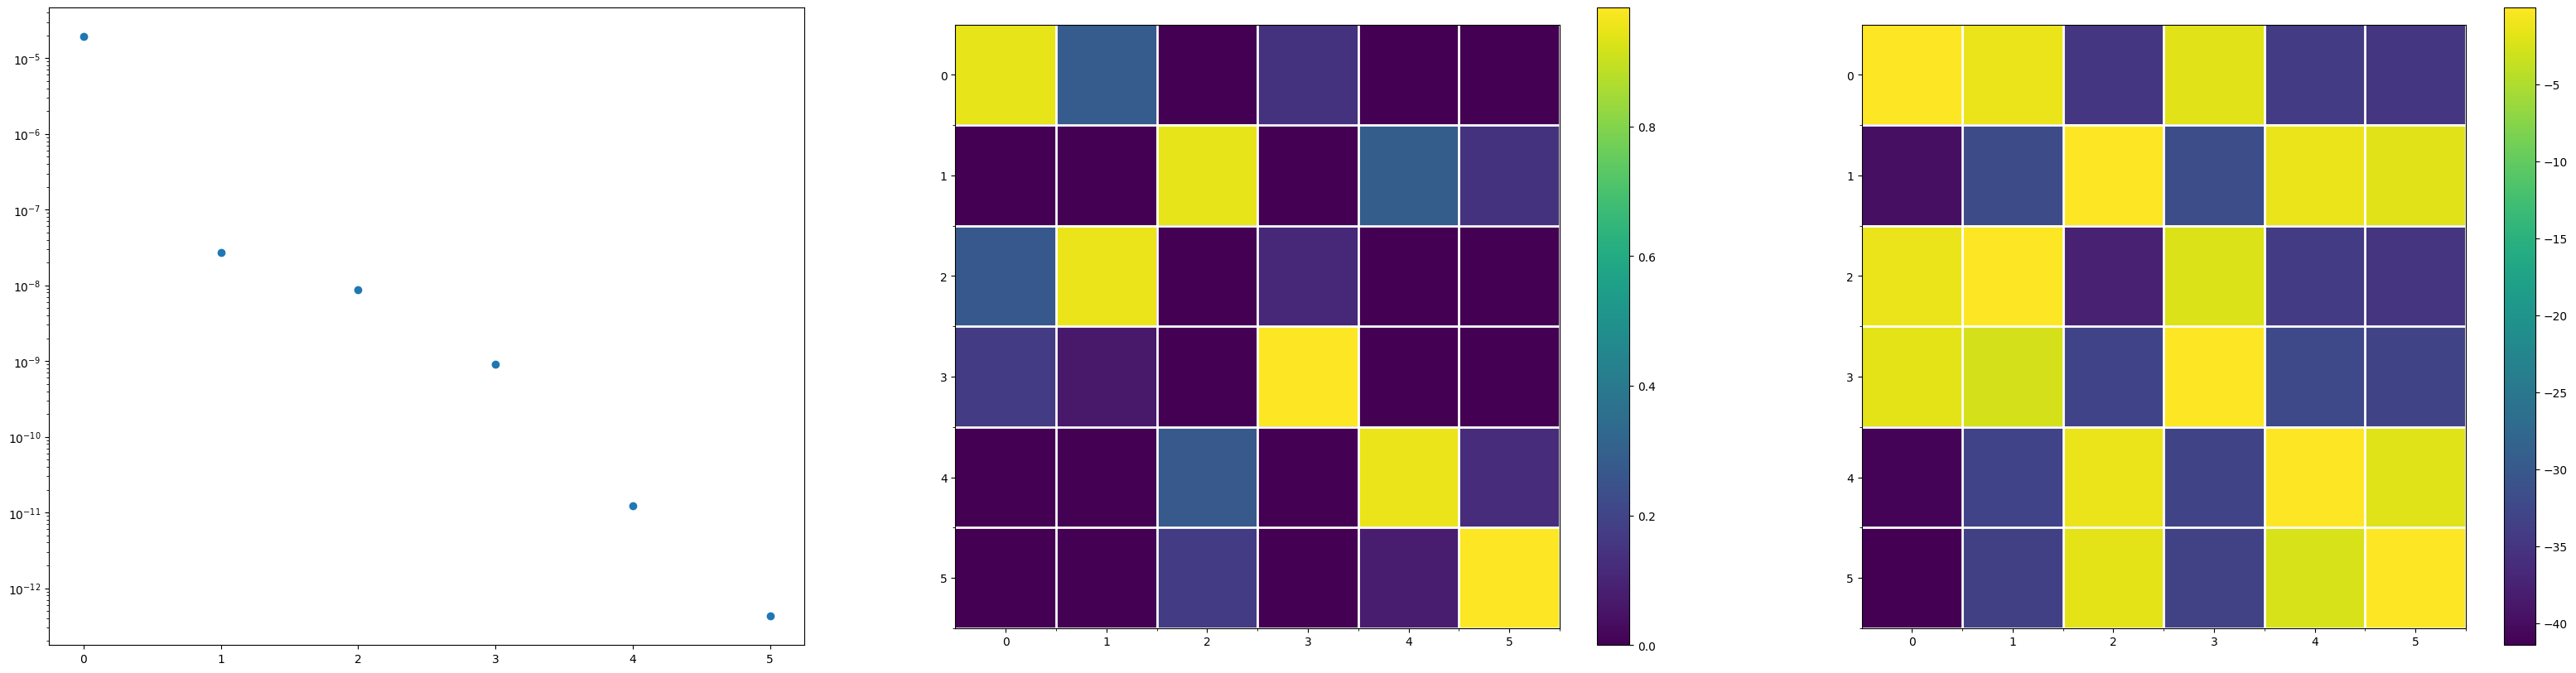

In [25]:
eigvals, eigvecs = np.linalg.eig(F4)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

In [26]:
np.abs(F-Freg).sum()

0.00011260781088457718

In [27]:
np.abs(F-F4).sum()

9.022624763716155e-05

In [28]:
p[n:].reshape((n,n))

array([[-3.10071894,  0.28174615],
       [ 0.76902257, -2.87037789]])

In [29]:
preg[n:].reshape((n,n))

array([[-2.06796265,  1.84219155],
       [ 0.27826887, -1.95931976]])

In [30]:
p_lm[0][n:].reshape((n,n))

array([[-3.46656565,  4.73363955],
       [ 0.25953001, -1.96622401]])

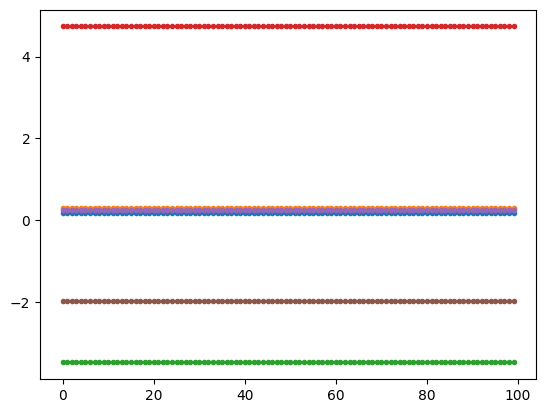

In [31]:
plt.plot(p_lm, ".")

In [32]:
mse(sol_reg, y)

0.000310857077217529

In [33]:
mse(sol3, y)

2.3503871631783276e-05